In [36]:
import os
from datetime import datetime
import torch
import torchvision.transforms as transforms
from utils.dataset import FashionDataset, AttributesDataset, mean, std
from utils.model import MultiOutputModel
from test import calculate_metrics, validate, visualize_grid
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [34]:
start_epoch = 1
num_epochs = 50
batch_size = 16
num_workers = 8  # number of processes to handle dataset loading
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'PyTorch will run on {device} device')

PyTorch will run on cuda device


In [35]:
# specify image transforms for augmentation during training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2),
                            shear=None, resample=False, fillcolor=(255, 255, 255)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# during validation we use only tensor and normalization transforms
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# attributes variable contains labels for the categories in the dataset and mapping between string names and IDs
attributes = AttributesDataset("./dataset/styles.csv")

train_dataset = FashionDataset('./train.csv', attributes, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_dataset = FashionDataset('./val.csv', attributes, val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

/home/wangkang/anaconda3/envs/pytorch/lib/python3.7/site-packages/torchvision/transforms/transforms.py:1362: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/home/wangkang/anaconda3/envs/pytorch/lib/python3.7/site-packages/torchvision/transforms/transforms.py:1376: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  "Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead"
/home/wangkang/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoade

/home/wangkang/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


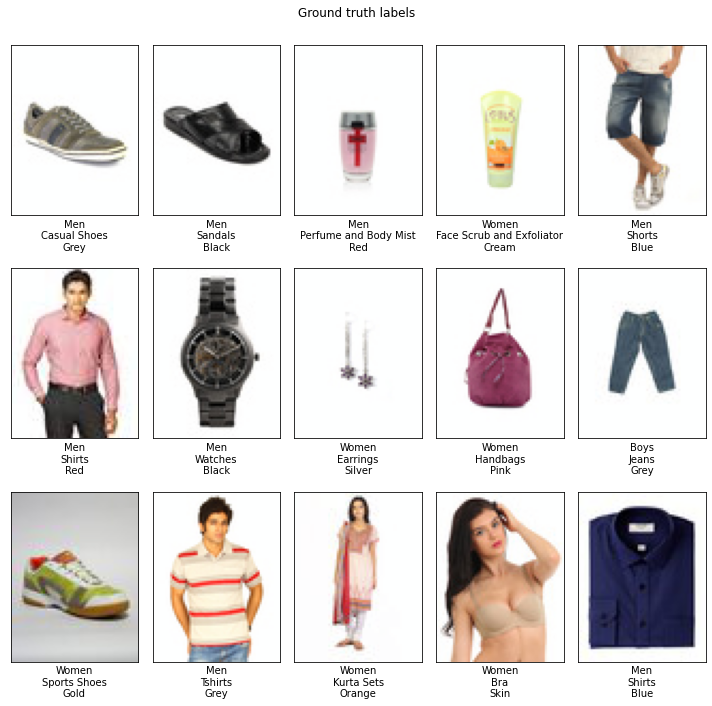

Starting training ...


In [30]:
def get_cur_time():
    return datetime.strftime(datetime.now(), '%Y-%m-%d_%H-%M')
    
def checkpoint_save(model, name, epoch):
    f = os.path.join(name, 'checkpoint-{:06d}.pth'.format(epoch))
    torch.save(model.state_dict(), f)
    print('Saved checkpoint:', f)
    
model = MultiOutputModel(n_color_classes=attributes.num_colors,
                             n_gender_classes=attributes.num_genders,
                             n_article_classes=attributes.num_articles)\
                            .to(device)
optimizer = torch.optim.Adam(model.parameters())
logdir = os.path.join('./logs/', get_cur_time())
savedir = os.path.join('./checkpoints/', get_cur_time())
os.makedirs(logdir, exist_ok=True)
os.makedirs(savedir, exist_ok=True)
logger = SummaryWriter(logdir)

n_train_samples = len(train_dataloader)

print("Starting training ...")
for epoch in range(start_epoch, num_epochs + 1):
        total_loss = 0
        accuracy_color = 0
        accuracy_gender = 0
        accuracy_article = 0

        for batch in train_dataloader:
            optimizer.zero_grad()

            img = batch['img']
            target_labels = batch['labels']
            target_labels = {t: target_labels[t].to(device) for t in target_labels}
            output = model(img.to(device))

            loss_train, losses_train = model.get_loss(output, target_labels)
            total_loss += loss_train.item()
            batch_accuracy_color, batch_accuracy_gender, batch_accuracy_article = \
                calculate_metrics(output, target_labels)

            accuracy_color += batch_accuracy_color
            accuracy_gender += batch_accuracy_gender
            accuracy_article += batch_accuracy_article

            loss_train.backward()
            optimizer.step()

        print("epoch {:4d}, loss: {:.4f}, color: {:.4f}, gender: {:.4f}, article: {:.4f}".format(
            epoch,
            total_loss / n_train_samples,
            accuracy_color / n_train_samples,
            accuracy_gender / n_train_samples,
            accuracy_article / n_train_samples))

        logger.add_scalar('train_loss', total_loss / n_train_samples, epoch)

        if epoch % 5 == 0:
            validate(model, val_dataloader, logger, epoch, device)

        if epoch % 25 == 0:
            checkpoint_save(model, savedir, epoch)